# Chat GPT o3-mini for Advanced Customer Segmentation

### Perform Customer Segmentation

RFM Table Sample:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40


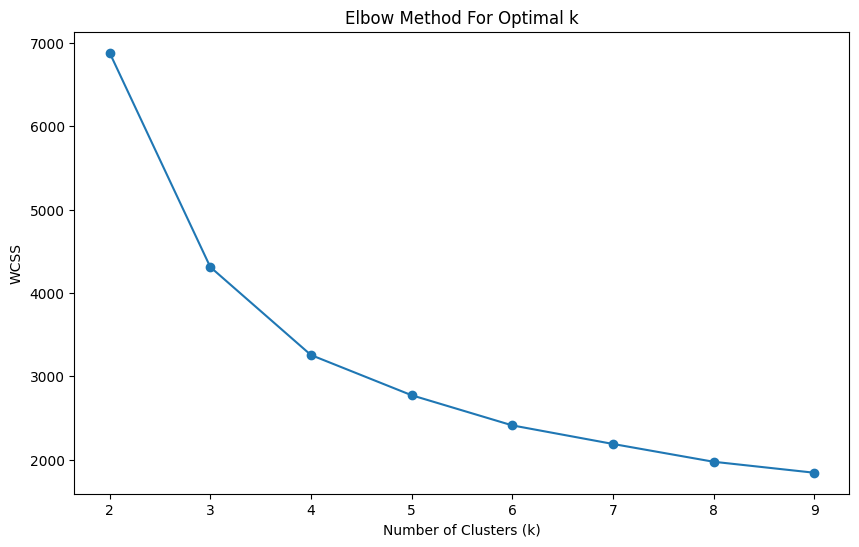

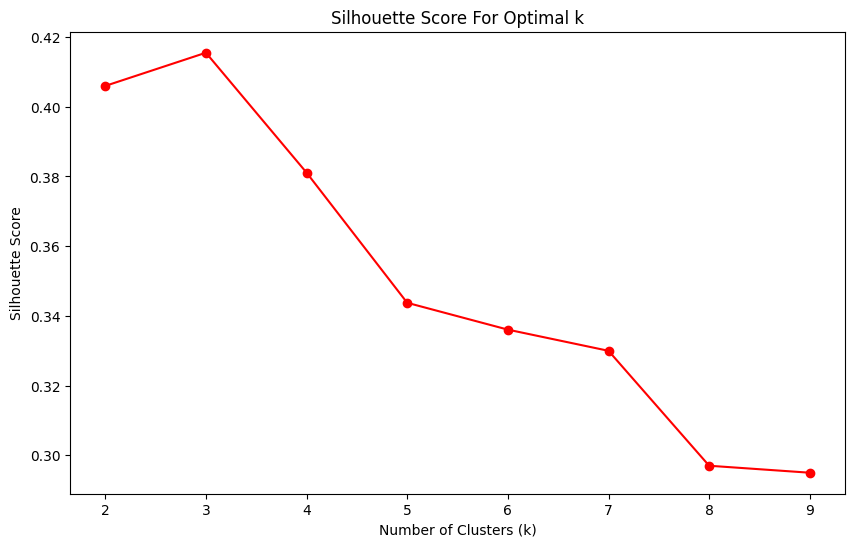


Cluster Centers (Standardized Values):
[[-0.34048173 -0.65577861 -0.64461521]
 [ 1.66668488 -0.75414667 -0.75784412]
 [-0.47957759  0.41437872  0.52233277]
 [-0.73259402  1.93881435  1.62668919]]

Cluster Centers (Original Scale of features):
      Recency  Frequency_log  Monetary_log
0   58.470754       0.897542      5.779077
1  259.183847       0.830351      5.636265
2   44.561416       1.628524      7.250908
3   19.260223       2.669804      8.643794

Cluster Summary:
   Cluster     Recency  Frequency      Monetary  Count
0        0   58.463881   1.528329    399.599802   1412
1        1  259.183847   1.375133    390.202827    941
2        2   44.749134   4.329175   1691.561922   1443
3        3   19.191529  16.274401  10200.862376    543


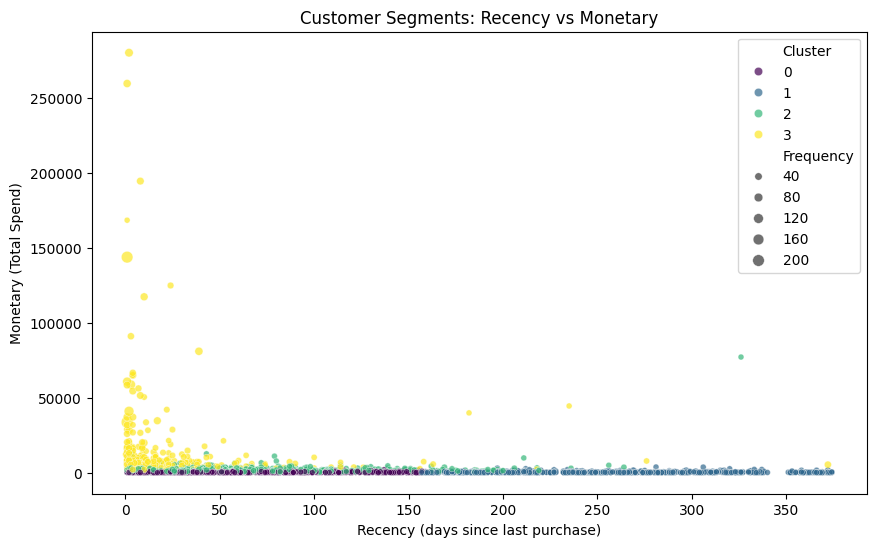

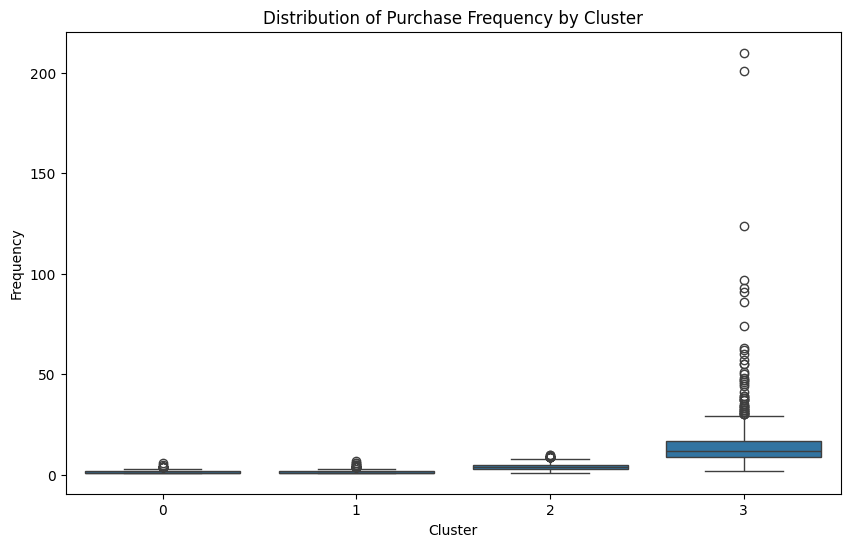

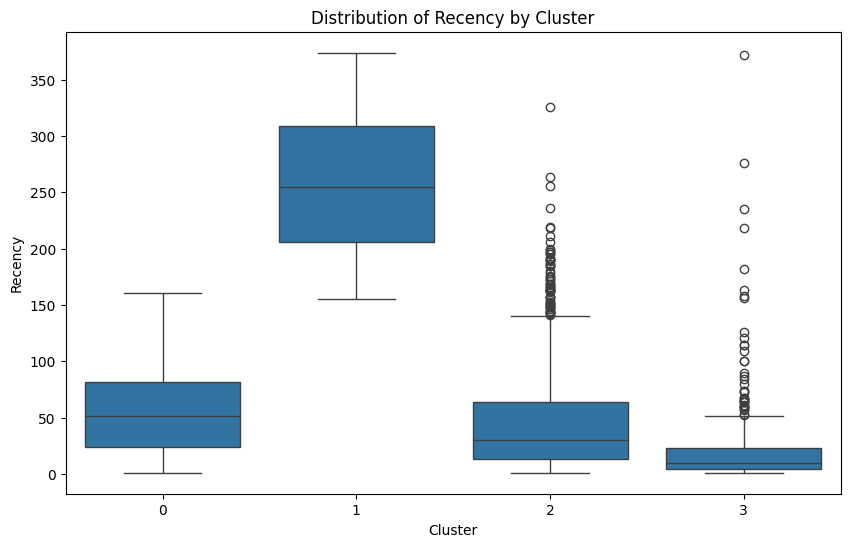

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Increase figure size for plots
plt.rcParams['figure.figsize'] = (10, 6)

# Step 1: Load the Data
url = "https://raw.githubusercontent.com/databricks/Spark-The-Definitive-Guide/refs/heads/master/data/retail-data/all/online-retail-dataset.csv"
df = pd.read_csv(url, encoding='ISO-8859-1')

# Step 2: Data Cleaning
# Remove transactions with cancellations (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C', na=False)]

# Remove transactions missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create TotalPrice column (Total amount per transaction line)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Step 3: Feature Engineering - Create RFM metrics

# Set a reference date for recency calculation:
# Here, we choose one day after the max invoice date in the dataset.
ref_date = df['InvoiceDate'].max() + timedelta(days=1)

# Compute RFM:
# - Recency: days since last purchase
# - Frequency: number of unique invoices
# - Monetary: total spend
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}).reset_index()

# Display first few rows of RFM table
print("RFM Table Sample:")
print(rfm.head())

# Step 4: Data Transformation
# RFM variables are usually skewed. Applying a log transformation to Frequency and Monetary can help.
rfm['Frequency_log'] = np.log1p(rfm['Frequency'])
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])
# (Recency might not need log transformation, but you can experiment.)

# For clustering, we will use Recency, Frequency_log, Monetary_log
features = rfm[['Recency', 'Frequency_log', 'Monetary_log']]

# Standardize features so that each contributes equally to the distance metric
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 5: Determine the Optimal Number of Clusters
# Use the Elbow Method and Silhouette Score
wcss = []  # within-cluster sum of squares
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(features_scaled, labels))

# Plot the Elbow curve
plt.plot(k_range, wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method For Optimal k")
plt.show()

# Plot the Silhouette scores for comparison
plt.plot(k_range, silhouette_scores, marker='o', color='red')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score For Optimal k")
plt.show()

# From the plots and scores, assume that k=4 provides a good balance.
optimal_k = 4

# Step 6: Fit the KMeans Model with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(features_scaled)

# Optional: Check cluster centers (in standardized space)
print("\nCluster Centers (Standardized Values):")
print(kmeans.cluster_centers_)

# Transform centers back to the original scale for interpretation:
centers_scaled = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers_scaled, columns=['Recency', 'Frequency_log', 'Monetary_log'])
print("\nCluster Centers (Original Scale of features):")
print(centers_df)

# Step 7: Analyze the Clusters

# Calculate the mean RFM values per cluster (using original, non-log values for business interpretation)
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).reset_index()

print("\nCluster Summary:")
print(cluster_summary)

# Visualize clusters with a scatter plot: Recency vs Monetary (size representing Frequency)
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', size='Frequency', palette='viridis', alpha=0.7)
plt.title("Customer Segments: Recency vs Monetary")
plt.xlabel("Recency (days since last purchase)")
plt.ylabel("Monetary (Total Spend)")
plt.show()

# You can also explore Frequency distribution across clusters:
sns.boxplot(x='Cluster', y='Frequency', data=rfm)
plt.title("Distribution of Purchase Frequency by Cluster")
plt.show()

# And Recency distribution:
sns.boxplot(x='Cluster', y='Recency', data=rfm)
plt.title("Distribution of Recency by Cluster")
plt.show()

# Step 8: Extracting Insights and Assessing Business Impact

# Based on the summary, you might see patterns such as:
#
# - **Cluster 0:** Customers with low recency (i.e., recent purchases), high frequency, and high monetary values.
#   *Business Impact:* These are your loyal and high-value customers. Focus on retention strategies, reward programs, and upselling opportunities.
#
# - **Cluster 1:** Customers with high recency (i.e., haven't purchased in a while), low frequency, and low monetary spend.
#   *Business Impact:* These might be at-risk or dormant customers. Develop re-engagement campaigns or special offers to reactivate them.
#
# - **Cluster 2:** Customers with moderate recency and frequency but variable monetary spend.
#   *Business Impact:* Analyze further for potential segmentation. Consider personalized promotions to boost their spending or increase purchase frequency.
#
# - **Cluster 3:** Customers with low frequency but moderate recency and high monetary spend.
#   *Business Impact:* These customers might be occasional big spenders. Consider targeted campaigns during special events or new product launches.
#
# **Business Action Steps:**
# 1. **Loyalty Programs:** For high-value clusters, design exclusive rewards, personalized offers, and proactive customer service.
# 2. **Reactivation Campaigns:** For segments with high recency, run email or SMS campaigns with incentives to re-engage these customers.
# 3. **Personalized Marketing:** Tailor promotions based on customer segment behaviors (e.g., upsell complementary products for high spenders).
# 4. **Resource Allocation:** Optimize marketing spend by focusing on segments that are likely to yield the highest return on investment.

# Step 9: Save or Export Clustered Data (optional)
# For further business analysis, you may want to export the customer segmentation results:
# rfm.to_csv("customer_segmentation_clusters.csv", index=False)

### Additional Enhancements

Data loaded and preprocessed. Sample:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


RFM table with cluster labels:


,CustomerID,Recency,Frequency,Monetary,Monetary_log,Cluster
0,12346.0,326,1,77183.60,11.253955,1
1,12347.0,2,7,4310.00,8.368925,1
2,12348.0,75,4,1797.24,7.494564,1
3,12349.0,19,1,1757.55,7.472245,1
4,12350.0,310,1,334.40,5.815324,3


Calculated Cluster Metrics (Raw Values):


,avg_quantity,sum_quantity,avg_unit_price,sum_unit_price,avg_total_price,sum_total_price,invoice_count,unique_product_count,mean_invoice_per_product,avg_product_count_per_invoice,avg_unit_price_per_invoice,avg_total_price_per_invoice,avg_total_price_sum_per_invoice,avg_quantity_sum_per_invoice,avg_unit_price_per_stock,avg_quantity_sum_per_stock,avg_total_price_per_stock,avg_total_price_sum_per_stock
Cluster,,,,,,,,,,,,,,,,,,
0,8.414300,764599,2.859918,259877.873,13.015501,1182705.593,4455,3314,26.383826,19.626487,3.839349,25.114668,265.478248,171.627160,3.301693,230.717864,11.702081,356.881591
1,13.287746,3264281,3.159925,776270.390,22.911379,5628432.210,10912,3481,69.092789,22.041056,6.927967,75.929273,515.802072,299.145986,3.613782,937.742315,66.661414,1616.900951
2,25.500730,925651,3.233334,117366.800,46.541666,1689415.920,1706,2980,11.908389,20.801290,10.817301,137.852735,990.278968,542.585580,3.163073,310.621141,40.825339,566.918094
3,9.052202,227165,3.446326,86485.551,16.371954,410854.181,1463,2753,8.877588,16.705400,5.220068,36.289622,280.829925,155.273411,3.563522,82.515438,14.067991,149.238714


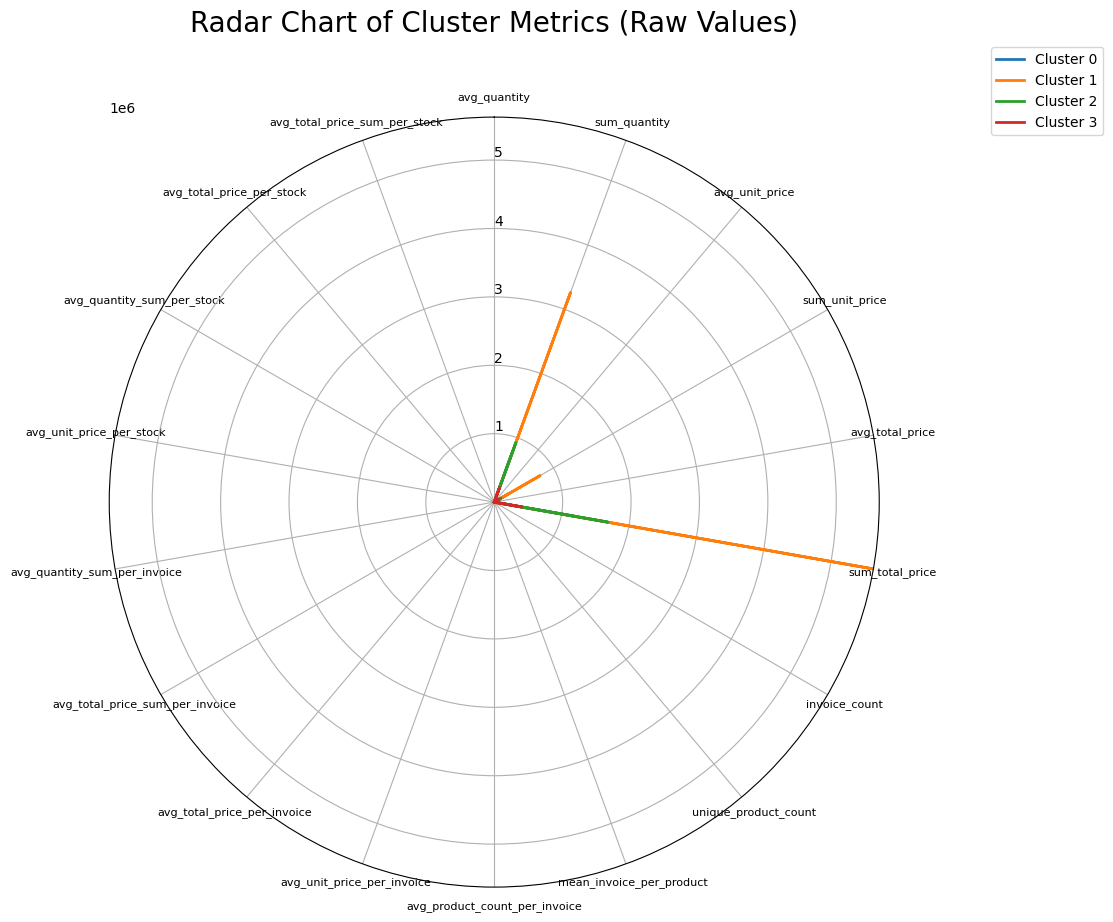

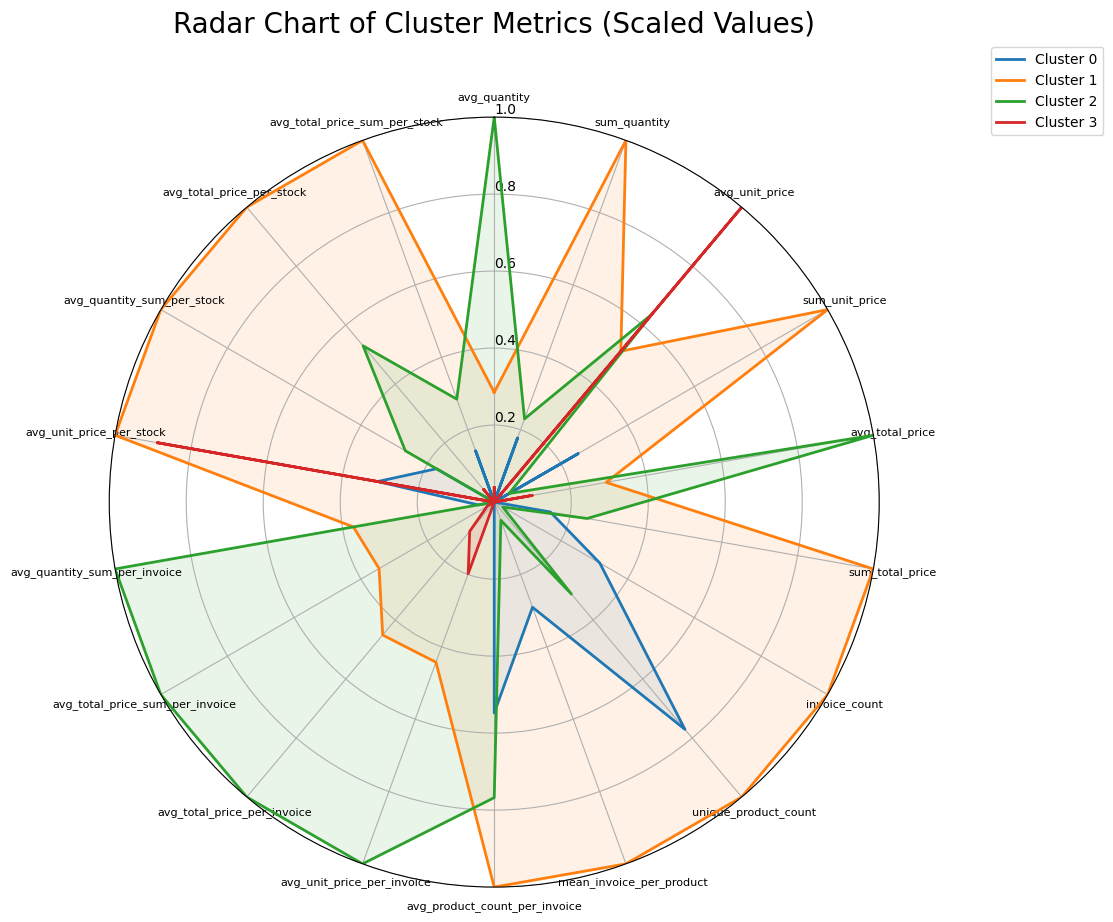


Insights and Business Strategies:

1. High-Value & Loyal Customers:
   - Clusters exhibiting high sums and averages in Total Price (both at the transaction and invoice level)
     and higher invoice counts tend to be high-value segments.
   - Strategy: Prioritize these customers with loyalty rewards, exclusive offers, and premium services 
     to further enhance customer lifetime value.

2. Bulk Buyers or Cost-Sensitive Segments:
   - Clusters with high Quantity sums and lower Unit Prices indicate bulk buying or price-sensitive behavior.
   - Strategy: Introduce volume discounts, bundle promotions, or loyalty pricing to incentivize repeat purchases.

3. Focused Product Purchases:
   - A high Mean Invoice Count Per Product signals that customers repeatedly purchase the same product.
   - Strategy: Use targeted promotions on these key products, and introduce complementary or upsell 
     items to diversify their purchases and increase the average order value.

4. Diverse Purchasing Pat

In [2]:
# %% [code]
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime

# For inline plotting in Colab
%matplotlib inline

# =============================================================================
# 1. DATA LOADING & PREPROCESSING
# =============================================================================

# Load the dataset
url = "https://raw.githubusercontent.com/databricks/Spark-The-Definitive-Guide/refs/heads/master/data/retail-data/all/online-retail-dataset.csv"
df = pd.read_csv(url, encoding='ISO-8859-1')

# Drop transactions with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove canceled invoices (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate Total Price for each transaction (ensure TotalPrice = Quantity x UnitPrice)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print("Data loaded and preprocessed. Sample:")
display(df.head())

# =============================================================================
# 2. CUSTOMER SEGMENTATION VIA RFM & KMEANS CLUSTERING
# =============================================================================

# Create an RFM table using CustomerID:
#   - Recency: Days since last purchase (using a reference date set as one day after the last invoice)
#   - Frequency: Count of unique invoices
#   - Monetary: Sum of TotalPrice

ref_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

# Rename columns for clarity
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# (Optional) Log-transform Monetary to reduce skewness
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])

# Use StandardScaler on the RFM features for clustering
features = ['Recency', 'Frequency', 'Monetary_log']
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[features])

# Assuming from the elbow method that k=4 is optimal
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print("RFM table with cluster labels:")
display(rfm.head())

# =============================================================================
# 3. MERGE CLUSTER ASSIGNMENT BACK TO TRANSACTION DATA
# =============================================================================

# Merge cluster assignment (from rfm) to the original transaction data (df) using CustomerID
df_cluster = pd.merge(df, rfm[['CustomerID', 'Cluster']], on='CustomerID', how='left')

# =============================================================================
# 4. CALCULATE STATISTICS PER CLUSTER
# =============================================================================

# (a) Transaction-level Aggregates per Cluster: Average and Sum of Quantity, UnitPrice, TotalPrice
agg_tran = df_cluster.groupby('Cluster').agg(
    avg_quantity=('Quantity', 'mean'),
    sum_quantity=('Quantity', 'sum'),
    avg_unit_price=('UnitPrice', 'mean'),
    sum_unit_price=('UnitPrice', 'sum'),
    avg_total_price=('TotalPrice', 'mean'),
    sum_total_price=('TotalPrice', 'sum')
)

# (b) Count of unique invoices per cluster
invoice_count = df_cluster.groupby('Cluster')['InvoiceNo'].nunique().rename("invoice_count")

# (c) Count of unique products per cluster (using StockCode as product identifier)
unique_product_count = df_cluster.groupby('Cluster')['StockCode'].nunique().rename("unique_product_count")

# (d) Mean Invoice Count Per Product:
#     For each (Cluster, StockCode), count unique InvoiceNo and then average across products.
prod_inv_counts = df_cluster.groupby(['Cluster', 'StockCode'])['InvoiceNo'].nunique()
mean_invoice_per_product = prod_inv_counts.groupby('Cluster').mean().rename("mean_invoice_per_product")

# (e) Number of Products Count per Invoice:
#     For each (Cluster, InvoiceNo), count distinct products (StockCode) then average across invoices.
inv_prod_counts = df_cluster.groupby(['Cluster', 'InvoiceNo'])['StockCode'].nunique()
avg_product_count_per_invoice = inv_prod_counts.groupby('Cluster').mean().rename("avg_product_count_per_invoice")

# (f) Unit Price Mean per Invoice:
#     For each invoice, compute the mean UnitPrice then average these values per cluster.
inv_unit_price_mean = df_cluster.groupby(['Cluster', 'InvoiceNo'])['UnitPrice'].mean()
avg_unit_price_per_invoice = inv_unit_price_mean.groupby('Cluster').mean().rename("avg_unit_price_per_invoice")

# (g) Total Price Mean per Invoice:
#     For each invoice, compute the mean TotalPrice then average these values per cluster.
inv_total_price_mean = df_cluster.groupby(['Cluster', 'InvoiceNo'])['TotalPrice'].mean()
avg_total_price_per_invoice = inv_total_price_mean.groupby('Cluster').mean().rename("avg_total_price_per_invoice")

# (h) Total Price Sum per Invoice:
#     For each invoice, compute the sum of TotalPrice then average these sums per cluster.
inv_total_price_sum = df_cluster.groupby(['Cluster', 'InvoiceNo'])['TotalPrice'].sum()
avg_total_price_sum_per_invoice = inv_total_price_sum.groupby('Cluster').mean().rename("avg_total_price_sum_per_invoice")

# (i) Quantity Sum per Invoice:
#     For each invoice, compute the sum of Quantity then average these sums per cluster.
inv_quantity_sum = df_cluster.groupby(['Cluster', 'InvoiceNo'])['Quantity'].sum()
avg_quantity_sum_per_invoice = inv_quantity_sum.groupby('Cluster').mean().rename("avg_quantity_sum_per_invoice")

# (j) Unit Price Mean per Stock:
#     For each product (StockCode) within a cluster, compute the mean UnitPrice then average over products.
stock_unit_price_mean = df_cluster.groupby(['Cluster', 'StockCode'])['UnitPrice'].mean()
avg_unit_price_per_stock = stock_unit_price_mean.groupby('Cluster').mean().rename("avg_unit_price_per_stock")

# (k) Quantity Sum per Stock:
#     For each product, compute the sum of Quantity then average over products.
stock_quantity_sum = df_cluster.groupby(['Cluster', 'StockCode'])['Quantity'].sum()
avg_quantity_sum_per_stock = stock_quantity_sum.groupby('Cluster').mean().rename("avg_quantity_sum_per_stock")

# (l) Total Price Mean per Stock:
#     For each product, compute the mean TotalPrice then average over products.
stock_total_price_mean = df_cluster.groupby(['Cluster', 'StockCode'])['TotalPrice'].mean()
avg_total_price_per_stock = stock_total_price_mean.groupby('Cluster').mean().rename("avg_total_price_per_stock")

# (m) Total Price Sum per Stock:
#     For each product, compute the sum of TotalPrice then average over products.
stock_total_price_sum = df_cluster.groupby(['Cluster', 'StockCode'])['TotalPrice'].sum()
avg_total_price_sum_per_stock = stock_total_price_sum.groupby('Cluster').mean().rename("avg_total_price_sum_per_stock")

# Combine all metrics into one DataFrame
cluster_metrics = pd.concat([
    agg_tran, invoice_count, unique_product_count, mean_invoice_per_product,
    avg_product_count_per_invoice, avg_unit_price_per_invoice, avg_total_price_per_invoice,
    avg_total_price_sum_per_invoice, avg_quantity_sum_per_invoice, avg_unit_price_per_stock,
    avg_quantity_sum_per_stock, avg_total_price_per_stock, avg_total_price_sum_per_stock
], axis=1)

print("Calculated Cluster Metrics (Raw Values):")
display(cluster_metrics)

# =============================================================================
# 5. RADAR PLOT VISUALIZATION
# =============================================================================

# Define a function to plot radar (spider) charts for a given DataFrame
def plot_radar(data, title, radial_max):
    categories = list(data.columns)
    N = len(categories)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # Adjust the placement of labels and set limits
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories, fontsize=8)
    ax.set_rlabel_position(0)
    ax.set_ylim(0, radial_max)

    # Plot each cluster's metrics as a polygon
    for idx, row in data.iterrows():
        values = row.tolist()
        values += values[:1]  # Repeat the first value to close the polygon
        ax.plot(angles, values, linewidth=2, label=f"Cluster {idx}")
        ax.fill(angles, values, alpha=0.1)

    plt.title(title, size=20, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# --- Radar Plot 1: Raw Values ---
# For raw values, use the overall maximum value among all metrics as the radial limit.
raw_radial_max = cluster_metrics.max().max()
plot_radar(cluster_metrics, "Radar Chart of Cluster Metrics (Raw Values)", raw_radial_max)

# --- Radar Plot 2: Scaled Values ---
# Scale each metric column to the range [0, 1] for comparability.
scaler_mm = MinMaxScaler()
cluster_metrics_scaled = pd.DataFrame(scaler_mm.fit_transform(cluster_metrics),
                                      index=cluster_metrics.index,
                                      columns=cluster_metrics.columns)
plot_radar(cluster_metrics_scaled, "Radar Chart of Cluster Metrics (Scaled Values)", 1)

# =============================================================================
# 6. INSIGHTS & BUSINESS STRATEGIES
# =============================================================================

print("""
Insights and Business Strategies:

1. High-Value & Loyal Customers:
   - Clusters exhibiting high sums and averages in Total Price (both at the transaction and invoice level)
     and higher invoice counts tend to be high-value segments.
   - Strategy: Prioritize these customers with loyalty rewards, exclusive offers, and premium services
     to further enhance customer lifetime value.

2. Bulk Buyers or Cost-Sensitive Segments:
   - Clusters with high Quantity sums and lower Unit Prices indicate bulk buying or price-sensitive behavior.
   - Strategy: Introduce volume discounts, bundle promotions, or loyalty pricing to incentivize repeat purchases.

3. Focused Product Purchases:
   - A high Mean Invoice Count Per Product signals that customers repeatedly purchase the same product.
   - Strategy: Use targeted promotions on these key products, and introduce complementary or upsell
     items to diversify their purchases and increase the average order value.

4. Diverse Purchasing Patterns:
   - Metrics such as the average number of products per invoice and the Unit Price Mean per Invoice provide
     insights into the breadth of customer purchases.
   - Strategy: Tailor cross-selling or up-selling strategies to encourage customers to explore a wider
     range of products, thereby increasing basket size.

By leveraging these insights, businesses can optimize marketing spend, tailor personalized promotions,
and design customer engagement strategies to maximize revenue potential.
""")

## End